In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,7)

import seaborn as sns
from datetime import datetime, timedelta

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy import stats
import statsmodels.api as sm
from itertools import product

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.5/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [5]:
df = pd.read_csv("./sequences/sequence_2018_05_03-16.54.37.csv")
#pd.to_datetime(df.index, unit='ms')
#df.index =  pd.to_datetime(df.index, unit='s')
df['date'] = pd.date_range(start='1/1/1900', periods=len(df.attr_1), freq='4D')
df.set_index('date', inplace=True)
#df = DataFrame(index=df['date'], data =(df))

#print(df)

In [6]:
# msk = np.random.rand(len(df)) < 0.9
# train = df[msk]
# test = df[~msk]
spl = int(len(df.attr_1)*0.9)
print(spl)
train = df.iloc[:spl, :]
test = df.iloc[spl-1000:, :]
print(test.shape)
print(train.shape)
#print(test)

12780
(2420, 4)
(12780, 4)


Dickey–Fuller test: p=0.000239


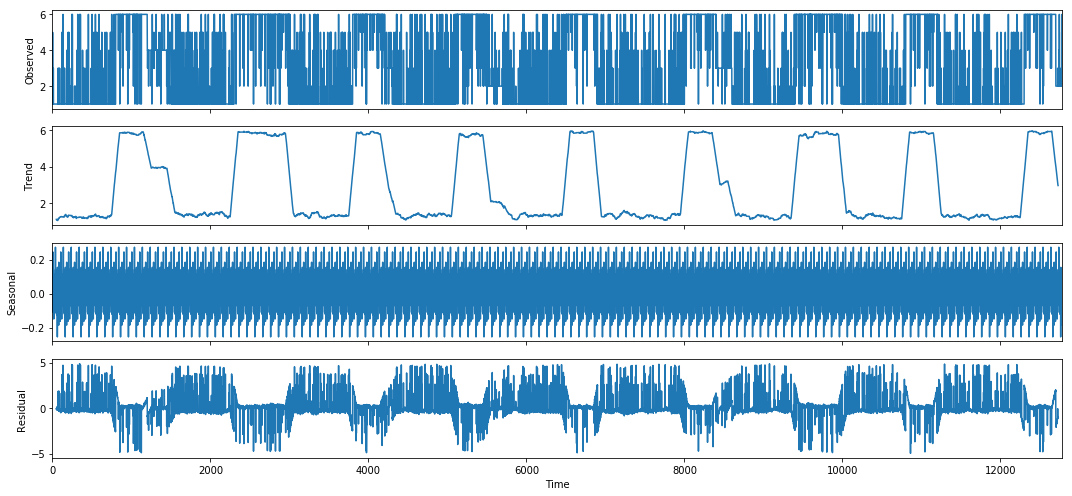

In [7]:
#seasonal_decompose(btc_month.close, freq=12).plot()
seasonal_decompose(np.asarray(train["attr_4"]), freq=100).plot()
print("Dickey–Fuller test: p=%f" % adfuller(train["attr_4"])[1])
plt.show()

In [9]:
train.tail()

,attr_1,attr_2,attr_3,attr_4
date,,,,
2039-11-28,4.0,4.0,1.0,5.0
2039-12-02,4.0,4.0,1.0,2.0
2039-12-06,4.0,1.0,1.0,2.0
2039-12-10,4.0,4.0,1.0,6.0
2039-12-14,4.0,4.0,1.0,2.0


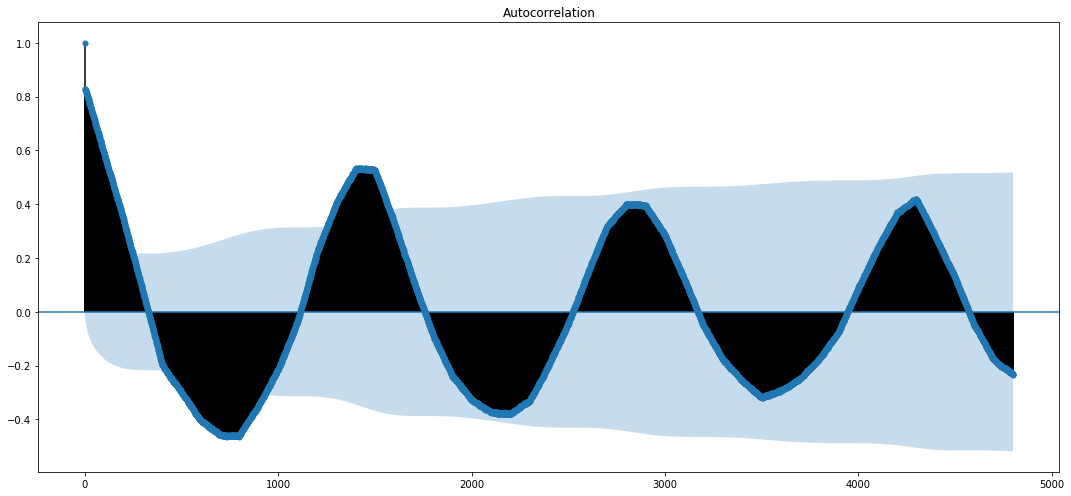

In [10]:
#autocorrelation_plot(btc_month.close)
plot_acf(train.attr_4[1:].values.squeeze(), lags=4800)

plt.tight_layout()
plt.show()

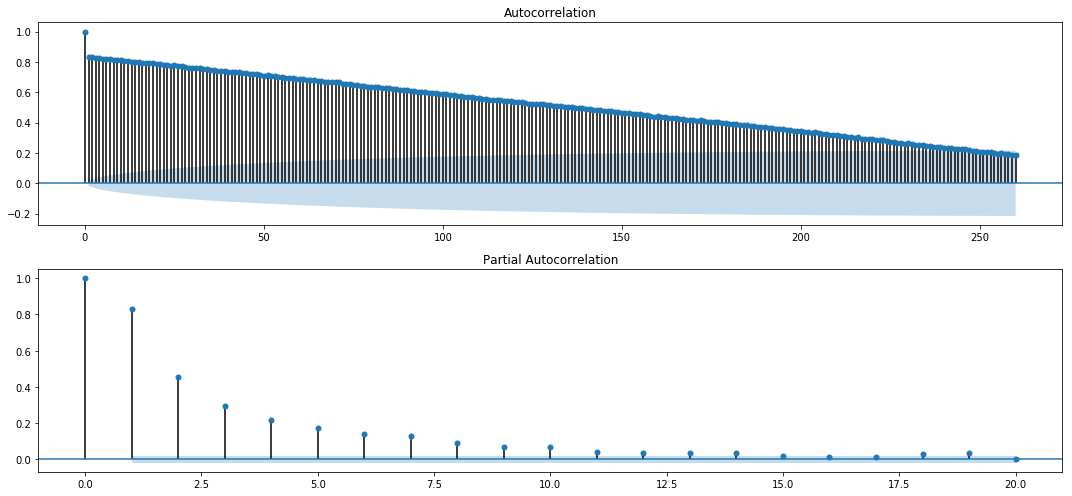

In [11]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
ax = plt.subplot(211)
# Plot the autocorrelation function
#sm.graphics.tsa.plot_acf(btc_month.box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plot_acf(train.attr_4[1:].values.squeeze(), lags=260, ax=ax)
ax = plt.subplot(212)
#sm.graphics.tsa.plot_pacf(btc_month.box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plot_pacf(train.attr_4[1:].values.squeeze(), lags=20, ax=ax)
plt.tight_layout()
plt.show()

In [27]:
# Initial approximation of parameters
qs = range(25, 35)
ps = range(15, 17)
d=1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
#warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(train.attr_4, order=(param[0], d, param[1]))
        res = model.fit(disp=False)
        print("model: ", param)
        print('eic: ', res.aic)
        print()
    except ValueError as e: 
        print('error:', e)
        print('bad parameter combination: ', param)
        print()
        continue
    aic = res.aic
    if aic < best_aic:
        best_model = res 
        best_aic = aic
        best_param = param
        print('best pram:', best_param)
    results.append([param, res.aic])

error: On entry to DLASCL parameter number 4 had an illegal value
bad parameter combination:  (15, 25)

error: On entry to DLASCL parameter number 4 had an illegal value
bad parameter combination:  (15, 26)

error: On entry to DLASCL parameter number 4 had an illegal value
bad parameter combination:  (15, 27)

error: On entry to DLASCL parameter number 4 had an illegal value
bad parameter combination:  (15, 28)

error: On entry to DLASCL parameter number 4 had an illegal value
bad parameter combination:  (15, 29)

error: On entry to DLASCL parameter number 4 had an illegal value
bad parameter combination:  (15, 30)

error: On entry to DLASCL parameter number 4 had an illegal value
bad parameter combination:  (15, 31)

error: On entry to DLASCL parameter number 4 had an illegal value
bad parameter combination:  (15, 32)

error: On entry to DLASCL parameter number 4 had an illegal value
bad parameter combination:  (15, 33)

error: On entry to DLASCL parameter number 4 had an illegal valu

  parameters           aic
0   (16, 28)  36592.224429
1   (16, 31)  36602.916076
2   (16, 32)  36605.875560
3   (16, 34)  36611.284141


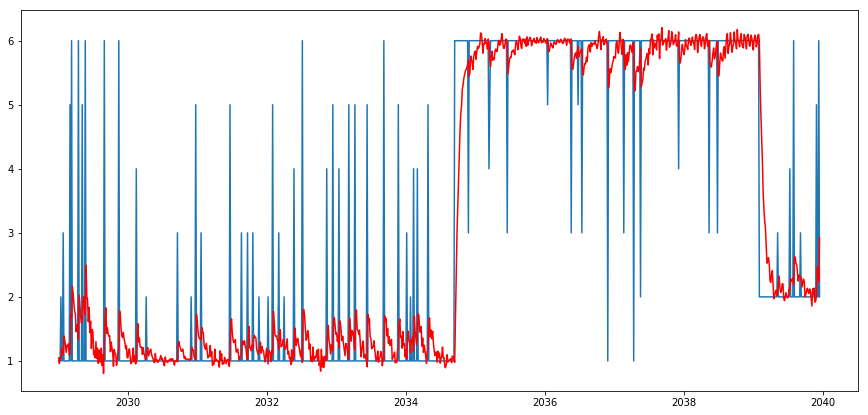

In [28]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head()) 
# parameters           aic
# 0      (0, 1)  36581.336961
# 5      (1, 1)  36582.133944
# 1      (0, 2)  36582.150843
# 10     (2, 1)  36583.667192
# 2      (0, 3)  36583.685588

plt.plot(train.attr_4[-1000:])
plt.plot(best_model.fittedvalues[-1000:], color='red')
plt.show()

In [29]:
print(best_model.summary())

                           Statespace Model Results                           
Dep. Variable:                 attr_4   No. Observations:                12780
Model:             SARIMAX(16, 1, 28)   Log Likelihood              -18251.112
Date:                Tue, 03 Jul 2018   AIC                          36592.224
Time:                        21:35:06   BIC                          36927.728
Sample:                    01-01-1900   HQIC                         36704.419
                         - 12-14-2039                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2201      1.905     -0.640      0.522      -4.954       2.514
ar.L2         -1.1696      3.150     -0.371      0.710      -7.343       5.004
ar.L3         -0.9412      4.109     -0.229      0.8

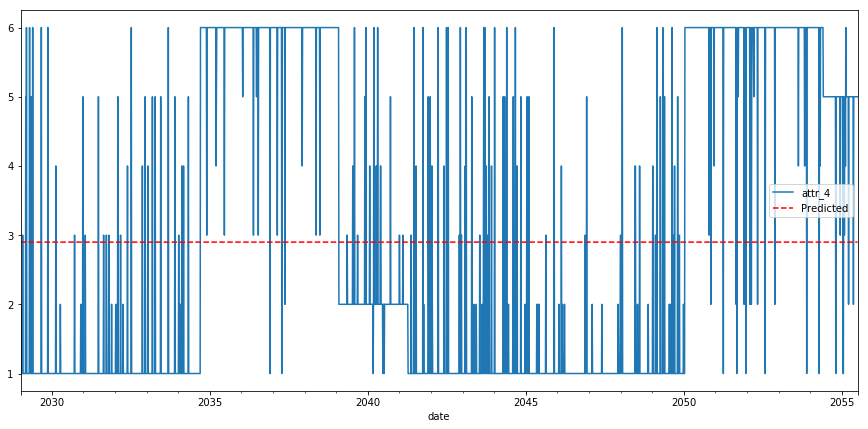

date
2029-01-04    2.899089
2029-01-08    2.899089
2029-01-12    2.899089
2029-01-16    2.899089
2029-01-20    2.899089
2029-01-24    2.899089
2029-01-28    2.899089
2029-02-01    2.899089
2029-02-05    2.899089
2029-02-09    2.899089
2029-02-13    2.899089
2029-02-17    2.899089
2029-02-21    2.899089
2029-02-25    2.899089
2029-03-01    2.899089
2029-03-05    2.899089
2029-03-09    2.899089
2029-03-13    2.899089
2029-03-17    2.899089
2029-03-21    2.899089
2029-03-25    2.899089
2029-03-29    2.899089
2029-04-02    2.899089
2029-04-06    2.899089
2029-04-10    2.899089
2029-04-14    2.899089
2029-04-18    2.899089
2029-04-22    2.899089
2029-04-26    2.899089
2029-04-30    2.899089
                ...   
2055-03-09    2.899089
2055-03-13    2.899089
2055-03-17    2.899089
2055-03-21    2.899089
2055-03-25    2.899089
2055-03-29    2.899089
2055-04-02    2.899089
2055-04-06    2.899089
2055-04-10    2.899089
2055-04-14    2.899089
2055-04-18    2.899089
2055-04-22    2.899089
2055-0

In [31]:
# Prediction
attr_4_pred = test[['attr_4']]
attr_4_pred['forecast'] = best_model.forecast(steps=len(test.attr_4))[0] #invboxcox(best_model.predict(start=datetime(2014, 1, 31), end=datetime(2018, 6, 30)), lmbda)
#attr_4_pred['forecast'] = best_model.predict(start=datetime(2029,1,4),end=datetime(2055,7,3)) #, dynamic=True, full_results=True

plt.figure(figsize=(15,7))
attr_4_pred.attr_4.plot()
attr_4_pred.forecast.plot(color='r', ls='--', label='Predicted')
plt.legend()
#plt.title('Bitcoin monthly forecast')
#plt.ylabel('USD')
plt.show()

attr_4_pred['forecast']

In [22]:
test.head()

,attr_1,attr_2,attr_3,attr_4
date,,,,
2029-01-04,2.0,4.0,1.0,1.0
2029-01-08,2.0,4.0,1.0,1.0
2029-01-12,2.0,4.0,1.0,1.0
2029-01-16,2.0,4.0,1.0,2.0
2029-01-20,2.0,4.0,1.0,1.0


In [ ]:
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
#        model = SARIMAX(btc_month.close_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
        model = SARIMAX(train.attr_4[341:], order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 25)).fit(disp=-1)
        print(param)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

bad parameter combination: (0, 0, 0, 0)
(0, 0, 0, 1)

In [33]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters           aic
6   (0, 1, 0, 1)  36606.744315
24  (1, 1, 0, 1)  36607.606120
8   (0, 1, 1, 1)  36608.624920
42  (2, 1, 0, 1)  36609.036808
26  (1, 1, 1, 1)  36609.135202
                                 Statespace Model Results                                
Dep. Variable:                            attr_4   No. Observations:                12780
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 4)   Log Likelihood              -18300.372
Date:                           Tue, 03 Jul 2018   AIC                          36606.744
Time:                                   22:29:50   BIC                          36629.111
Sample:                               01-01-1900   HQIC                         36614.224
                                    - 12-14-2039                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------

In [34]:
print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])

Dickey–Fuller test:: p=0.000000


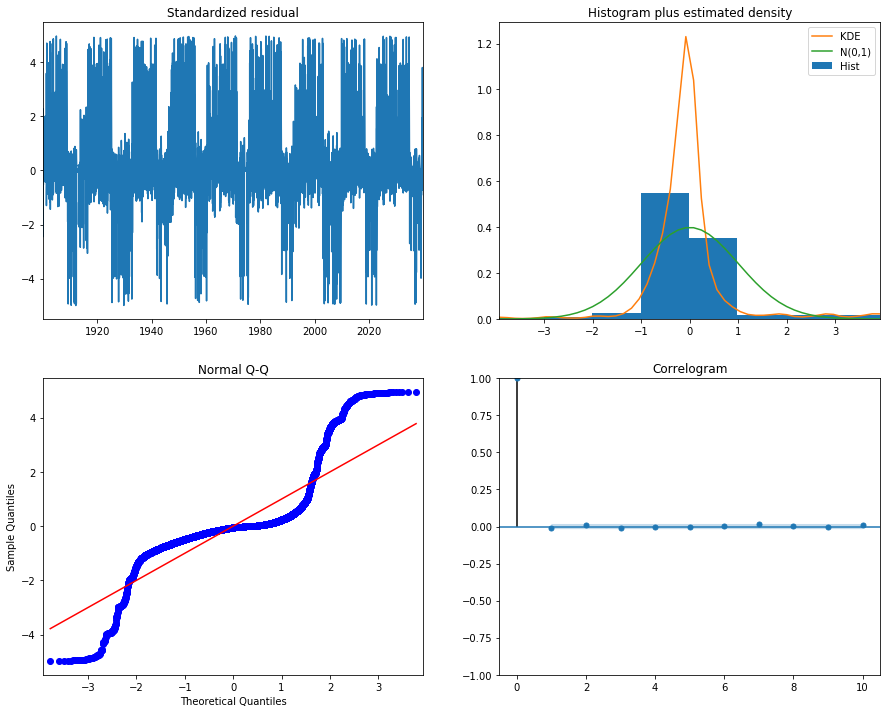

In [35]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

Dickey–Fuller test:: p=0.000000


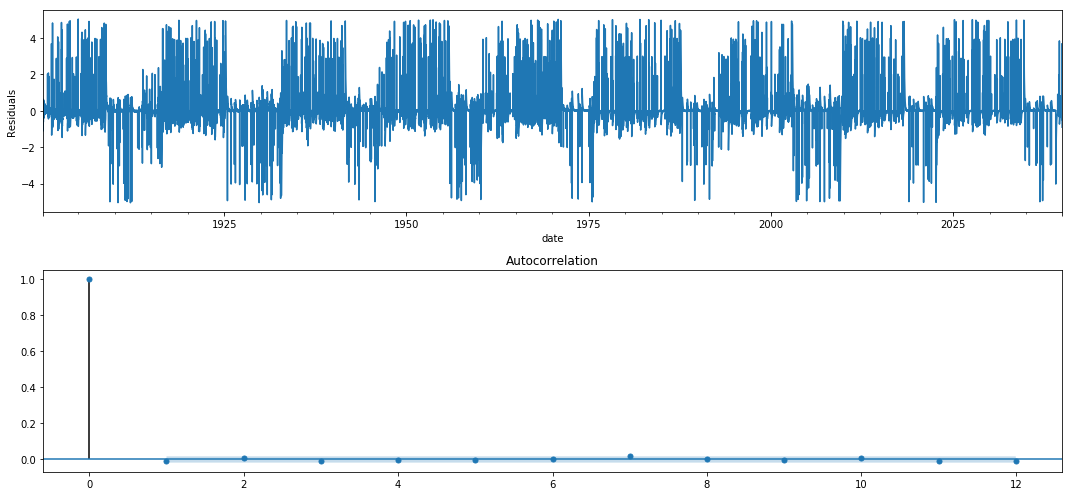

In [36]:
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
#sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)
plot_acf(best_model.resid[13:].values.squeeze(), lags=12, ax=ax)

print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

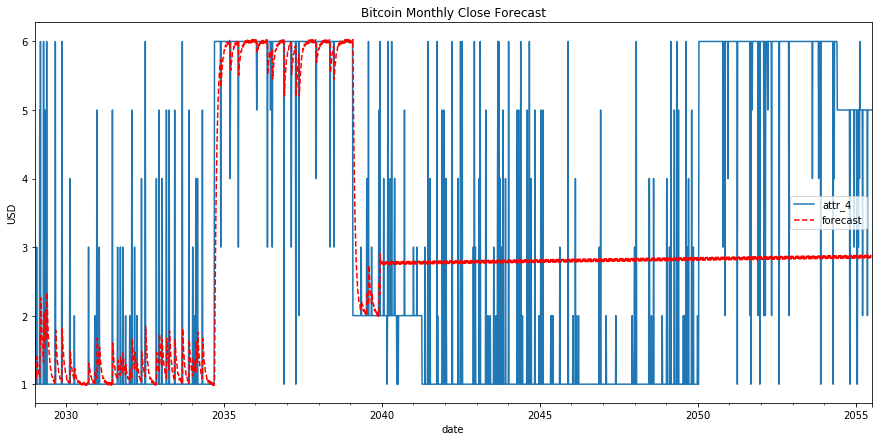

In [37]:
# Prediction
#btc_month2 = btc_month[['close']]
#date_list = [datetime(2018, 3, 31), datetime(2018, 4, 30), datetime(2018, 5, 31), datetime(2018, 6, 30)]
#future = pd.DataFrame(index=date_list, columns= btc_month.columns)
#btc_month2 = pd.concat([btc_month2, future])

#btc_month2['forecast'] = invboxcox(best_model.predict(start=0, end=75), lmbda)

attr_4_pred = test[['attr_4']]
#attr_4_pred['forecast'] = best_model.forecast(steps=len(test.attr_4))[0] #invboxcox(best_model.predict(start=datetime(2014, 1, 31), end=datetime(2018, 6, 30)), lmbda)
attr_4_pred['forecast'] = best_model.predict(start=datetime(2029,1,4),end=datetime(2055,7,3)) #, dynamic=True, full_results=True



plt.figure(figsize=(15,7))
attr_4_pred.attr_4.plot()
attr_4_pred.forecast.plot(color='r', ls='--', label='forecast')
plt.legend()
plt.title('Bitcoin Monthly Close Forecast')
plt.ylabel('USD')
plt.savefig('bitcoin_monthly_forecast.png')
plt.show()

In [38]:
y_forecasted = attr_4_pred.forecast
y_truth = test.attr_4

# Compute the root mean square error
rmse = np.sqrt(((y_forecasted - y_truth) ** 2).mean())
print('Mean Squared Error: {}'.format(round(rmse, 2)))

Mean Squared Error: 1.79
